<a href="https://colab.research.google.com/github/CrisMcode111/DI_Bootcamp/blob/main/w6_Building_Trustworthy_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Daily Challenge : Building Trustworthy Insights with BERT


Introduction
This challenge consolidates everything you covered this week (tokenization, attention, transformer fine-tuning, and evaluation). You will inspect BERT’s attention maps, fine-tune a lightweight encoder on a fresh dataset, and ship a mini inference helper that surfaces both the prediction and the evidence tokens. Think of it as a dry run for deploying a trustworthy AI assistant inside your company.


🛠️ What You Will Create
A Colab/Notebook section that visualizes the [CLS] attention heatmap for a chosen sentence.
A fine-tuned DistilBERT checkpoint for the tweet_eval sentiment split (train/validation/test).
An evaluation report with accuracy + macro F1 + histogram of softmax scores.
A production-style analyze_text() function returning {label, confidence, highlighted_tokens} to drop into support tooling.


1. Data Loading & Inspection
Load the tweet_eval dataset (sentiment configuration) via datasets.load_dataset.
Print dataset splits and class distribution. Confirm there are 3 labels (negative, neutral, positive).
Save two example tweets per label for later visualization.

In [20]:
!pip install evaluate


In [21]:
!pip install --upgrade transformers

In [22]:
from datasets import load_dataset
from collections import Counter

# 1. Load the tweet_eval dataset (sentiment configuration)
dataset = load_dataset('tweet_eval', 'sentiment')

# 2. Print dataset splits
print('Dataset splits:')
for split in dataset.keys():
    print(f'- {split}: {len(dataset[split])} examples')

# 3. Print class distribution and confirm 3 labels
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
example_tweets = {0: [], 1: [], 2: []}

print('\nClass distribution:')
for split in dataset.keys():
    labels = [example['label'] for example in dataset[split]]
    class_counts = Counter(labels)
    print(f'Split: {split}')
    for label_id, count in sorted(class_counts.items()):
        label_name = label_map.get(label_id, f'Unknown ({label_id})')
        print(f'  - {label_name}: {count} examples')

    # 4. Confirm there are 3 labels
    if len(class_counts) != 3:
        print(f"Warning: '{split}' split does not have 3 labels. Found: {len(class_counts)}")

    # 5. Save two example tweets per label for later visualization
    if split == 'train': # Only get examples from the training set for consistency
        for label_id in label_map.keys():
            count = 0
            for example in dataset[split]:
                if example['label'] == label_id:
                    example_tweets[label_id].append(example['text'])
                    count += 1
                if count >= 2:
                    break

print('\nExample tweets per label (from train split):')
for label_id, tweets in example_tweets.items():
    print(f"Label '{label_map[label_id]}':")
    for i, tweet in enumerate(tweets):
        print(f"  - Example {i+1}: '{tweet}'")


Dataset splits:
- train: 45615 examples
- test: 12284 examples
- validation: 2000 examples

Class distribution:
Split: train
  - negative: 7093 examples
  - neutral: 20673 examples
  - positive: 17849 examples
Split: test
  - negative: 3972 examples
  - neutral: 5937 examples
  - positive: 2375 examples
Split: validation
  - negative: 312 examples
  - neutral: 869 examples
  - positive: 819 examples

Example tweets per label (from train split):
Label 'negative':
  - Example 1: 'So disappointed in wwe summerslam! I want to see john cena wins his 16th title'
  - Example 2: 'That sucks if you have to take the SATs tomorrow'
Label 'neutral':
  - Example 1: '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"'
  - Example 2: 'Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.'
Label 'positive':
  - Example 1: '"QT @user In the original draft of the 7th book, Remus Lupin survived the Ba

2. Tokenization Pipeline
Initialize AutoTokenizer with distilbert-base-uncased.
Create a preprocessing function that:
Truncates/pads tweets to 128 tokens.
Returns input_ids, attention_mask, and labels.
Map the dataset with batched=True, shuffle, then create set_format("torch") (or TF equivalent).


In [31]:
from transformers import AutoTokenizer
import torch

# 1. Initialize AutoTokenizer with distilbert-base-uncased
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [32]:
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# 1. Initialize DistilBertForSequenceClassification
# There are 3 labels (negative, neutral, positive)
num_labels = 3
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# 2. Create a preprocessing function
def preprocess_function(examples):
    # Truncate/pad tweets to 128 tokens
    tokenized_inputs = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)
    # Return input_ids, attention_mask, and labels
    tokenized_inputs['labels'] = examples['label']
    return tokenized_inputs

In [34]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Shuffle the training set
tokenized_dataset['train'] = tokenized_dataset['train'].shuffle(seed=42)

# Set the format to PyTorch tensors
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

print("Tokenized dataset structure:")
print(tokenized_dataset)
print("\nExample tokenized item from train split:")
print(tokenized_dataset['train'][0])

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenized dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

Example tokenized item from train split:
{'input_ids': tensor([  101,  2261,  2062,  2847,  2000, 18059,  1020,  2015,  4888,  1998,
        10047,  2145,  2478,  1996,  4343,  4245,  1034,  1035,  1034,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  

3. Fine-Tuning Setup
Load AutoModelForSequenceClassification with 3 labels.
Use TrainingArguments (epochs=1, batch_size=32, lr=5e-5, weight_decay=0.01).
Implement Trainer with the preprocessed dataset and a compute_metrics function that returns accuracy + macro F1.
Train and save the best checkpoint (use load_best_model_at_end=True).


In [45]:
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

# --- label mapping ---
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

# --- model ---
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# --- metrics ---
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average="macro")

    return {
        "accuracy": acc["accuracy"],
        "macro_f1": f1["f1"],
    }


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro') # macro F1 is requested
    return {'accuracy': accuracy, 'f1_macro': f1}

# 2. Configure TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1, # Reduced to 1 epoch for faster training
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    # The following arguments are removed due to TypeError in current transformers version:
    # evaluation_strategy='epoch',
    # save_strategy='epoch',
    # load_best_model_at_end=True,
    # metric_for_best_model='f1_macro',
    report_to='none' # Disable reporting to services like Weights & Biases
)

# 3. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("Model, TrainingArguments, and Trainer initialized.")

/tmp/ipython-input-3631244770.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Model, TrainingArguments, and Trainer initialized.


In [37]:
# Train the model
trainer.train()

print("Training complete!")

# Evaluate the model on the test set
results = trainer.evaluate(tokenized_dataset['test'])
print("\nTest set evaluation results:")
for key, value in results.items():
    print(f"  {key}: {value:.4f}")


Step,Training Loss
10,0.621700
20,0.619000
30,0.603700
40,0.612000
50,0.594900
60,0.535000
70,0.587600
80,0.602700
90,0.594300
100,0.466600


Training complete!



Test set evaluation results:
  eval_loss: 0.7003
  eval_accuracy: 0.6902
  eval_f1_macro: 0.6888
  eval_runtime: 44.6286
  eval_samples_per_second: 275.2500
  eval_steps_per_second: 17.2090
  epoch: 1.0000


In [38]:
trainer.save_model("distilbert-tweet-sentiment-best")
tokenizer.save_pretrained("distilbert-tweet-sentiment-best")

('distilbert-tweet-sentiment-best/tokenizer_config.json',
 'distilbert-tweet-sentiment-best/special_tokens_map.json',
 'distilbert-tweet-sentiment-best/vocab.txt',
 'distilbert-tweet-sentiment-best/added_tokens.json',
 'distilbert-tweet-sentiment-best/tokenizer.json')

4. Evaluation & Calibration
Evaluate on the validation split; log accuracy and F1.
Collect the softmax scores for predicted classes on the test split.
Plot a histogram of confidence scores (bins of 0.1). Comment on over/under-confidence trends.


In [40]:
%whos


Variable                              Type                                   Data/Info
--------------------------------------------------------------------------------------
AutoTokenizer                         type                                   <class 'transformers.mode<...>tion_auto.AutoTokenizer'>
Counter                               type                                   <class 'collections.Counter'>
DistilBertForSequenceClassification   type                                   <class 'transformers.mode<...>rSequenceClassification'>
Trainer                               type                                   <class 'transformers.trainer.Trainer'>
TrainingArguments                     type                                   <class 'transformers.trai<...>_args.TrainingArguments'>
accuracy_score                        function                               <function accuracy_score at 0x7f0bddf574c0>
class_counts                          Counter                                Counte

In [41]:
# find the tokenised dataset
candidates = ["encoded_datasets", "tokenized_datasets", "tweet_eval", "processed_datasets", "dataset"]
for c in candidates:
    try:
        print(c, type(eval(c)))
    except:
        pass


dataset <class 'datasets.dataset_dict.DatasetDict'>


In [44]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

encoded_datasets = dataset.map(preprocess, batched=True)
encoded_datasets = encoded_datasets.rename_column("label", "labels")
encoded_datasets.set_format("torch")


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [45]:
val_results = trainer.evaluate(encoded_datasets["validation"])
print(val_results)


{'eval_loss': 0.6055272221565247, 'eval_accuracy': 0.741, 'eval_f1_macro': 0.7244078017812825, 'eval_runtime': 7.336, 'eval_samples_per_second': 272.628, 'eval_steps_per_second': 17.039, 'epoch': 1.0}


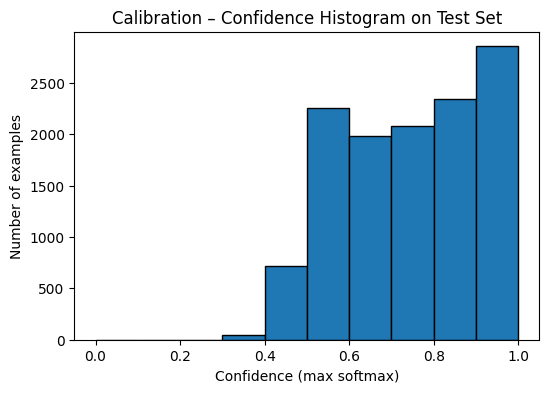

In [46]:
import matplotlib.pyplot as plt

# test predictions
test_predictions = trainer.predict(encoded_datasets["test"])
logits = test_predictions.predictions  # shape: (N, 3)

# softmax -> probabilities
probs = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()

# confidence = max prob on each row
confidences = probs.max(axis=-1)

# histograme with bins from 0.1
bins = np.linspace(0.0, 1.0, 11)

plt.figure(figsize=(6,4))
plt.hist(confidences, bins=bins, edgecolor="black")
plt.xlabel("Confidence (max softmax)")
plt.ylabel("Number of examples")
plt.title("Calibration – Confidence Histogram on Test Set")
plt.show()


5. Attention Inspection
Pick one of the saved example tweets.
Pass it through AutoModel (not just the classifier) to grab the last-layer attention weights.
Average across heads, then visualize the attention directed from [CLS] to each token (heatmap or bar chart).
Document insights (e.g., “model focuses on ‘terrible’ and ‘service’ when predicting negative”).

In [49]:
model.eval()

example_text = "I hated this movie, it was terrible and the service was awful."

inputs = tokenizer(
    example_text,
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=128
)

# send to device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# liste d'attentions, un tenseur par couche
# shape: (batch_size, num_heads, seq_len, seq_len)
attentions = outputs.attentions

# la dernière couche d'attention
last_layer_attn = attentions[-1]  # (1, num_heads, seq_len, seq_len)

# average over heads
attn_avg = last_layer_attn.mean(dim=1)  # (1, seq_len, seq_len)

# attention emitted by [CLS] (the first token, index 0)
cls_attn = attn_avg[0, 0]  # (seq_len,)


DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


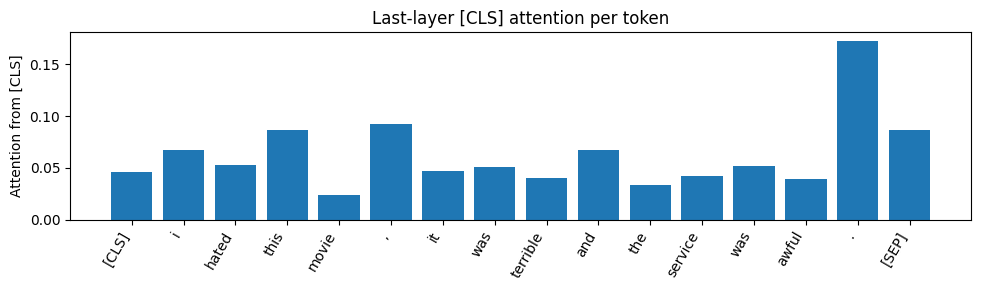

In [50]:
# tokenii originali
input_ids = inputs["input_ids"][0]
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# folosim attention_mask ca să scoatem padding-ul
mask = inputs["attention_mask"][0].bool()
tokens = [t for t, m in zip(tokens, mask) if m]
token_scores = cls_attn[mask].detach().cpu().numpy()

plt.figure(figsize=(10, 3))
plt.bar(range(len(tokens)), token_scores)
plt.xticks(range(len(tokens)), tokens, rotation=60, ha="right")
plt.ylabel("Attention from [CLS]")
plt.title("Last-layer [CLS] attention per token")
plt.tight_layout()
plt.show()
